In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def simple_cnn(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)  # (64, 64, 32)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)  # (32, 32, 64)

    # Decoder
    up1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(pool2)  # (64, 64, 32)
    up1 = concatenate([up1, conv2])  # Match shape before concatenation
    
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    
    up2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv3)  # (128, 128, 32)
    up2 = concatenate([up2, conv1])  # Now shapes match correctly

    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv4)

    return Model(inputs, outputs)

In [4]:
model = simple_cnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 64, 64, 32)        │           8,224 │ max_pooling2d_1[0][0]      │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 64, 64, 96)        │               0 │ conv2d_transpose[0][0],    │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 32)        │          27,680 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 128, 128, 32)      │           4,128 │ conv2d_2[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 128, 128, 64)      │               0 │ conv2d_transpose_1[0][0],  │
│                               │                           │                 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │          18,464 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 1)       │              33 │ conv2d_3[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 77,921 (304.38 KB)

 Trainable params: 77,921 (304.38 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


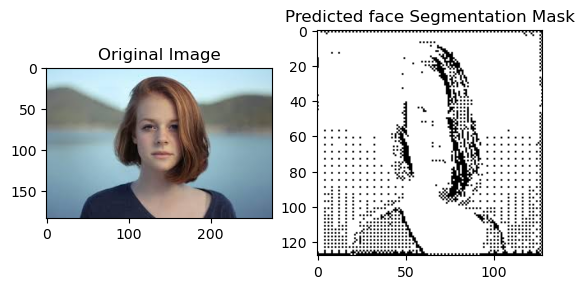

In [5]:
def predict_mask(image_path, model):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Load and preprocess the image
    img = cv2.imread(r"C:\Users\AI_LAB\Downloads\face img.jpg")
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict the mask
    pred_mask = model.predict(img)[0]  # Remove batch dimension
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Convert to binary mask

    # Show original image and predicted mask
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(image_path)[:, :, ::-1])  # Convert BGR to RGB
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted face Segmentation Mask")

    plt.show()

# Test on a sample image
predict_mask(r"C:\Users\AI_LAB\Downloads\face img.jpg", model)
